In [1]:
import sys, os
sys.path.append("C:\\Program Files\\Lumerical\\v231\\api\\python\\")
import lumapi
# sys.path.append(os.path.dirname(__file__))
import numpy as np
from tqdm import tqdm
import photonflux
import matplotlib.pyplot as plt

um = 1e-6
N_doping = 1e17 #In [cm-3]
NN_doping = 1E18
NNN_doping = 1E19
P_doping = 1E17
PP_doping = 1E18
PPP_doping = 1E19

cathode_min_voltage = -0.5
cathode_max_voltage = 4
cathode_voltage_sweep_num_points = 6

# Phase Shifting Efficiency

In [2]:
def run_full_sim(
    N_doping = 1e17, #In [cm-3]
    NN_doping = 1E18,
    NNN_doping = 1E19,
    P_doping = 1E17,
    PP_doping = 1E18,
    PPP_doping = 1E19,
    cathode_min_voltage = -0.5,
    cathode_max_voltage = 4,
    cathode_voltage_sweep_num_points = 11,
    hide=True,
    ):
    dev1 = lumapi.DEVICE(filename="lumerical_files/base_lateral_junction.ldev",hide=hide)
    dev1.switchtolayout()
    charge_object = dev1.select("CHARGE::boundary conditions::cathode")
    dev1.set("range start",cathode_min_voltage)
    dev1.set("range stop",cathode_max_voltage)
    dev1.set("range num points",cathode_voltage_sweep_num_points)

    charge_object = dev1.select("CHARGE::N")
    dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

    charge_object = dev1.select("CHARGE::NN")
    dev1.set("concentration",NN_doping*1E6)

    charge_object = dev1.select("CHARGE::NNN")
    dev1.set("concentration",NNN_doping*1E6)

    charge_object = dev1.select("CHARGE::P")
    dev1.set("concentration",P_doping*1E6)

    charge_object = dev1.select("CHARGE::PP")
    dev1.set("concentration",PP_doping*1E6)

    charge_object = dev1.select("CHARGE::PPP")
    dev1.set("concentration",PPP_doping*1E6)

    dev1.run("CHARGE")
    dev1.close()

    mode1 = lumapi.MODE(filename="lumerical_files/base_junction.lms",hide=hide)
    mode1.switchtolayout()
    mode1.select("np density")
    mode1.importdataset("charge.mat")

    neff_sweep_storage = []
    ng_sweep_storage = []

    for i in range(1,cathode_voltage_sweep_num_points+1):
        mode1.switchtolayout()
        mode1.select("np density")
        mode1.set("V_cathode_index",i)
        mode1.run("FDE")
        mode1.findmodes()
        mode1.selectmode(1)
        neff = mode1.getdata("FDE::data::mode1","neff")
        ng = mode1.getdata("FDE::data::mode1","ng")
        neff_sweep_storage.append(np.squeeze(neff))
        ng_sweep_storage.append(np.squeeze(ng))

    mode1.close()

    neff_sweep_storage = np.array(neff_sweep_storage)
    ng_sweep_storage = np.array(ng_sweep_storage)
    V_sweep = np.linspace(cathode_min_voltage,cathode_max_voltage,cathode_voltage_sweep_num_points)

    return V_sweep, neff_sweep_storage, ng_sweep_storage

# Bandwidth Measurements

In [3]:

def run_bandwidth_sim(
    N_doping = 1e17, #In [cm-3]
    NN_doping = 1E18,
    NNN_doping = 1E19,
    P_doping = 1E17,
    PP_doping = 1E18,
    PPP_doping = 1E19,
    cathode_min_voltage = -0.5,
    cathode_max_voltage = 4,
    cathode_voltage_sweep_num_points = 11,
    hide=True,
    ):
    # Get the anode resistance
    dev1 = lumapi.DEVICE(filename="lumerical_files/lateral_junction_anode_resistance.ldev",hide=hide)
    dev1.switchtolayout()

    charge_object = dev1.select("CHARGE::N")
    dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

    charge_object = dev1.select("CHARGE::NN")
    dev1.set("concentration",NN_doping*1E6)

    charge_object = dev1.select("CHARGE::NNN")
    dev1.set("concentration",NNN_doping*1E6)

    charge_object = dev1.select("CHARGE::P")
    dev1.set("concentration",P_doping*1E6)

    charge_object = dev1.select("CHARGE::PP")
    dev1.set("concentration",PP_doping*1E6)

    charge_object = dev1.select("CHARGE::PPP")
    dev1.set("concentration",PPP_doping*1E6)

    dev1.run("CHARGE")
    temp = dev1.getresult("CHARGE","anode")
    current_A_per_cm =  np.squeeze(temp['Ip'])
    current_A_per_m = current_A_per_cm*100
    anode_resistance = 0.1/current_A_per_m
    dev1.switchtolayout()
    dev1.close()

    # Get cathode resistance
    dev1 = lumapi.DEVICE(filename="lumerical_files/lateral_junction_cathode_resistance.ldev",hide=hide)
    dev1.switchtolayout()

    charge_object = dev1.select("CHARGE::N")
    dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

    charge_object = dev1.select("CHARGE::NN")
    dev1.set("concentration",NN_doping*1E6)

    charge_object = dev1.select("CHARGE::NNN")
    dev1.set("concentration",NNN_doping*1E6)

    charge_object = dev1.select("CHARGE::P")
    dev1.set("concentration",P_doping*1E6)

    charge_object = dev1.select("CHARGE::PP")
    dev1.set("concentration",PP_doping*1E6)

    charge_object = dev1.select("CHARGE::PPP")
    dev1.set("concentration",PPP_doping*1E6)

    dev1.run("CHARGE")
    temp = dev1.getresult("CHARGE","cathode")
    current_A_per_cm =  np.squeeze(temp['In'])
    current_A_per_m = current_A_per_cm*100
    cathode_resistance = 0.1/current_A_per_m
    dev1.switchtolayout()
    dev1.close()

    # Get capacitance
    dev1 = lumapi.DEVICE(filename="lumerical_files/lateral_junction_capacitance.ldev",hide=hide)
    dev1.switchtolayout()
    charge_object = dev1.select("CHARGE::boundary conditions::cathode");
    dev1.set("range start",cathode_min_voltage)
    dev1.set("range stop",cathode_max_voltage)
    dev1.set("range num points",cathode_voltage_sweep_num_points+1)
    electron_charge = 1.602e-19

    charge_object = dev1.select("CHARGE::N")
    dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

    charge_object = dev1.select("CHARGE::NN")
    dev1.set("concentration",NN_doping*1E6)

    charge_object = dev1.select("CHARGE::NNN")
    dev1.set("concentration",NNN_doping*1E6)

    charge_object = dev1.select("CHARGE::P")
    dev1.set("concentration",P_doping*1E6)

    charge_object = dev1.select("CHARGE::PP")
    dev1.set("concentration",PP_doping*1E6)

    charge_object = dev1.select("CHARGE::PPP")
    dev1.set("concentration",PPP_doping*1E6)

    dev1.run("CHARGE")
    Q = dev1.getresult("CHARGE::monitor_charge","total_charge")
    n =  electron_charge*np.squeeze(Q['n'])
    p =  electron_charge*np.squeeze(Q['p'])
    deltaV = (cathode_max_voltage - cathode_min_voltage)/(cathode_voltage_sweep_num_points+1)
    deltan = n[1:] - n[0:-1]
    deltap = p[1:] - p[0:-1]
    capacitance = np.abs(0.5*(deltan/deltaV + deltap/deltaV))
    dev1.switchtolayout()
    dev1.close()
    tau = capacitance*(anode_resistance+cathode_resistance)
    voltage_sweep = np.linspace(cathode_min_voltage,cathode_max_voltage,cathode_voltage_sweep_num_points+1)[1:]
    return voltage_sweep, anode_resistance, cathode_resistance, capacitance 

In [4]:
storage_dict = {}
num_sweep_points = 50
dopings = [1E16,3E16,1E17,3E17,1E18,3E18]
for i in tqdm(dopings,desc="Doping sweep"):
    voltage, neff, ng = run_full_sim(N_doping=i,P_doping=i,cathode_min_voltage=-0.5,cathode_max_voltage=5.0,cathode_voltage_sweep_num_points=num_sweep_points)
    bandwidth_voltage_sweep, anode_resistance, cathode_resistance, capacitance = run_bandwidth_sim(N_doping=i,P_doping=i,cathode_min_voltage=-0.5,cathode_max_voltage=5.0,cathode_voltage_sweep_num_points=num_sweep_points)
    temp = {
        "voltage":voltage,
        "neff":neff,
        "ng":ng,
        "bandwidth_voltage_sweep":bandwidth_voltage_sweep,
        "anode_resistance":anode_resistance,
        "cathode_resistance":cathode_resistance,
        "capacitance":capacitance
    }
    storage_dict[i] = temp

Doping sweep: 100%|██████████| 6/6 [3:27:50<00:00, 2078.36s/it]  


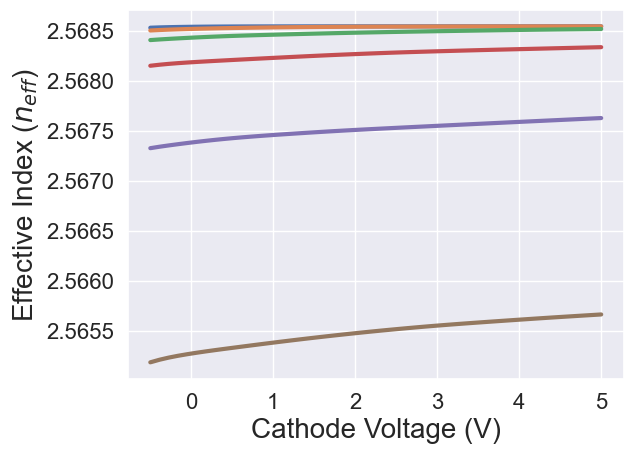

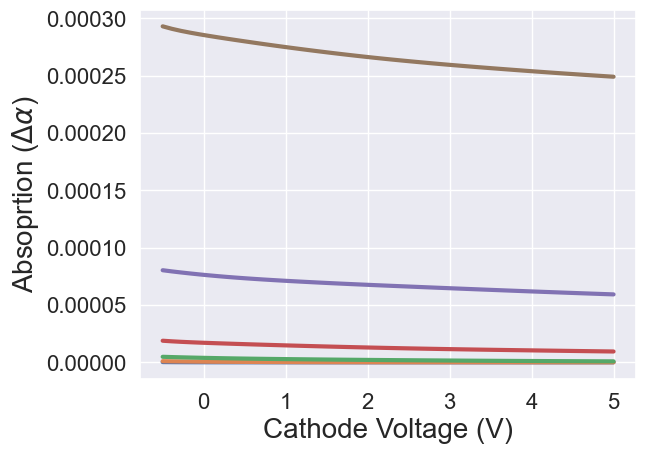

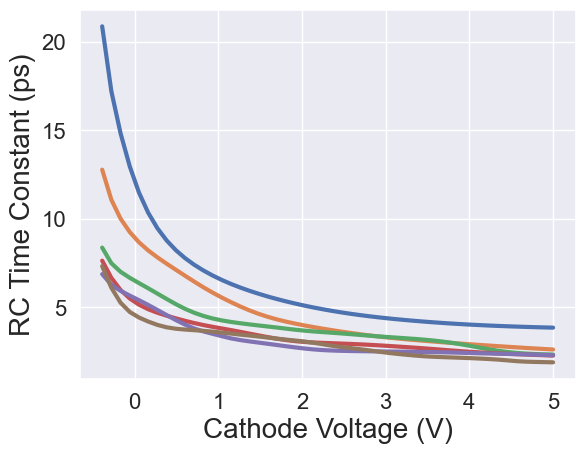

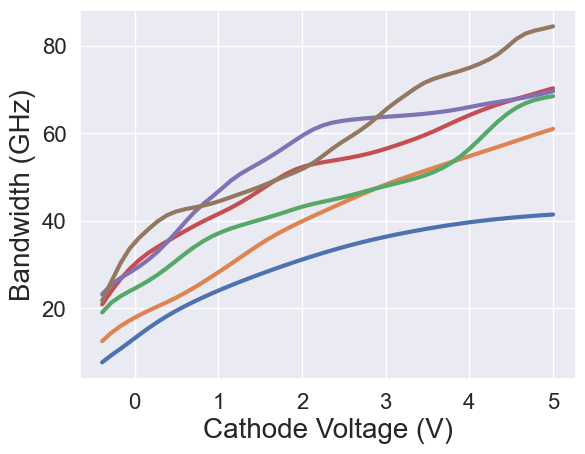

In [5]:
plt.figure()
for i in dopings:
    plt.plot(storage_dict[i]['voltage'],np.real(storage_dict[i]["neff"]))
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("Effective Index " + r"($n_{eff}$)")
plt.show()

plt.figure()
for i in dopings:
    plt.plot(storage_dict[i]["voltage"],np.imag(storage_dict[i]["neff"]))
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("Absoprtion " + r"($\Delta \alpha$)")
plt.show()


plt.figure()
for i in dopings:
    tau = (storage_dict[i]["anode_resistance"] + storage_dict[i]["cathode_resistance"]) * storage_dict[i]["capacitance"]
    plt.plot(storage_dict[i]["bandwidth_voltage_sweep"],tau*1e12)
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("RC Time Constant (ps)")
plt.show()

plt.figure()
for i in dopings:
    tau = (storage_dict[i]["anode_resistance"] + storage_dict[i]["cathode_resistance"]) * storage_dict[i]["capacitance"]
    f3dB = 1./(2*np.pi*tau)
    plt.plot(storage_dict[i]["bandwidth_voltage_sweep"],f3dB/1e9)
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("Bandwidth (GHz)")
plt.show()

In [6]:
import pickle

with open("lateral_doping.pkl",'wb') as f:
    pickle.dump(storage_dict,f)